# Audio Classification of heartbeat related data

In [1]:
#!pip install --upgrade torch torchvision torchaudio

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchaudio

import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import random
from PIL import Image
import numpy as np

In [3]:
data_path = Path('data')
wave_source_path = data_path / 'set_a'


## Data Exploration

In [4]:
# Helper functions for plotting. 
# Source:https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram).squeeze(), origin="lower", aspect="auto", interpolation="nearest")

In [5]:
transform = torchaudio.transforms.Spectrogram(n_fft=256)

In [6]:
def plot_wav_n_spec(filenames):
    fig, axs = plt.subplots(len(filenames), 2, figsize=(12, 16))
    
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        file_index = int(i/2)
        sample = plot_files[file_index]
        file = wave_source_path / sample
        type = sample.split('__')[0]
        waveform, sample_rate = torchaudio.load(file, normalize=True)
        if i % 2 == 0:
            plot_waveform(waveform, sample_rate, title=f"Waveform {type}", ax=ax)
        else:
            spectrogram = transform(waveform)
            plot_spectrogram(spectrogram, title=f"Spectrogram {type}", ylabel="freq_bin", ax=ax)
            
    
    plt.tight_layout()
    plt.show()

### Checking across the different sources

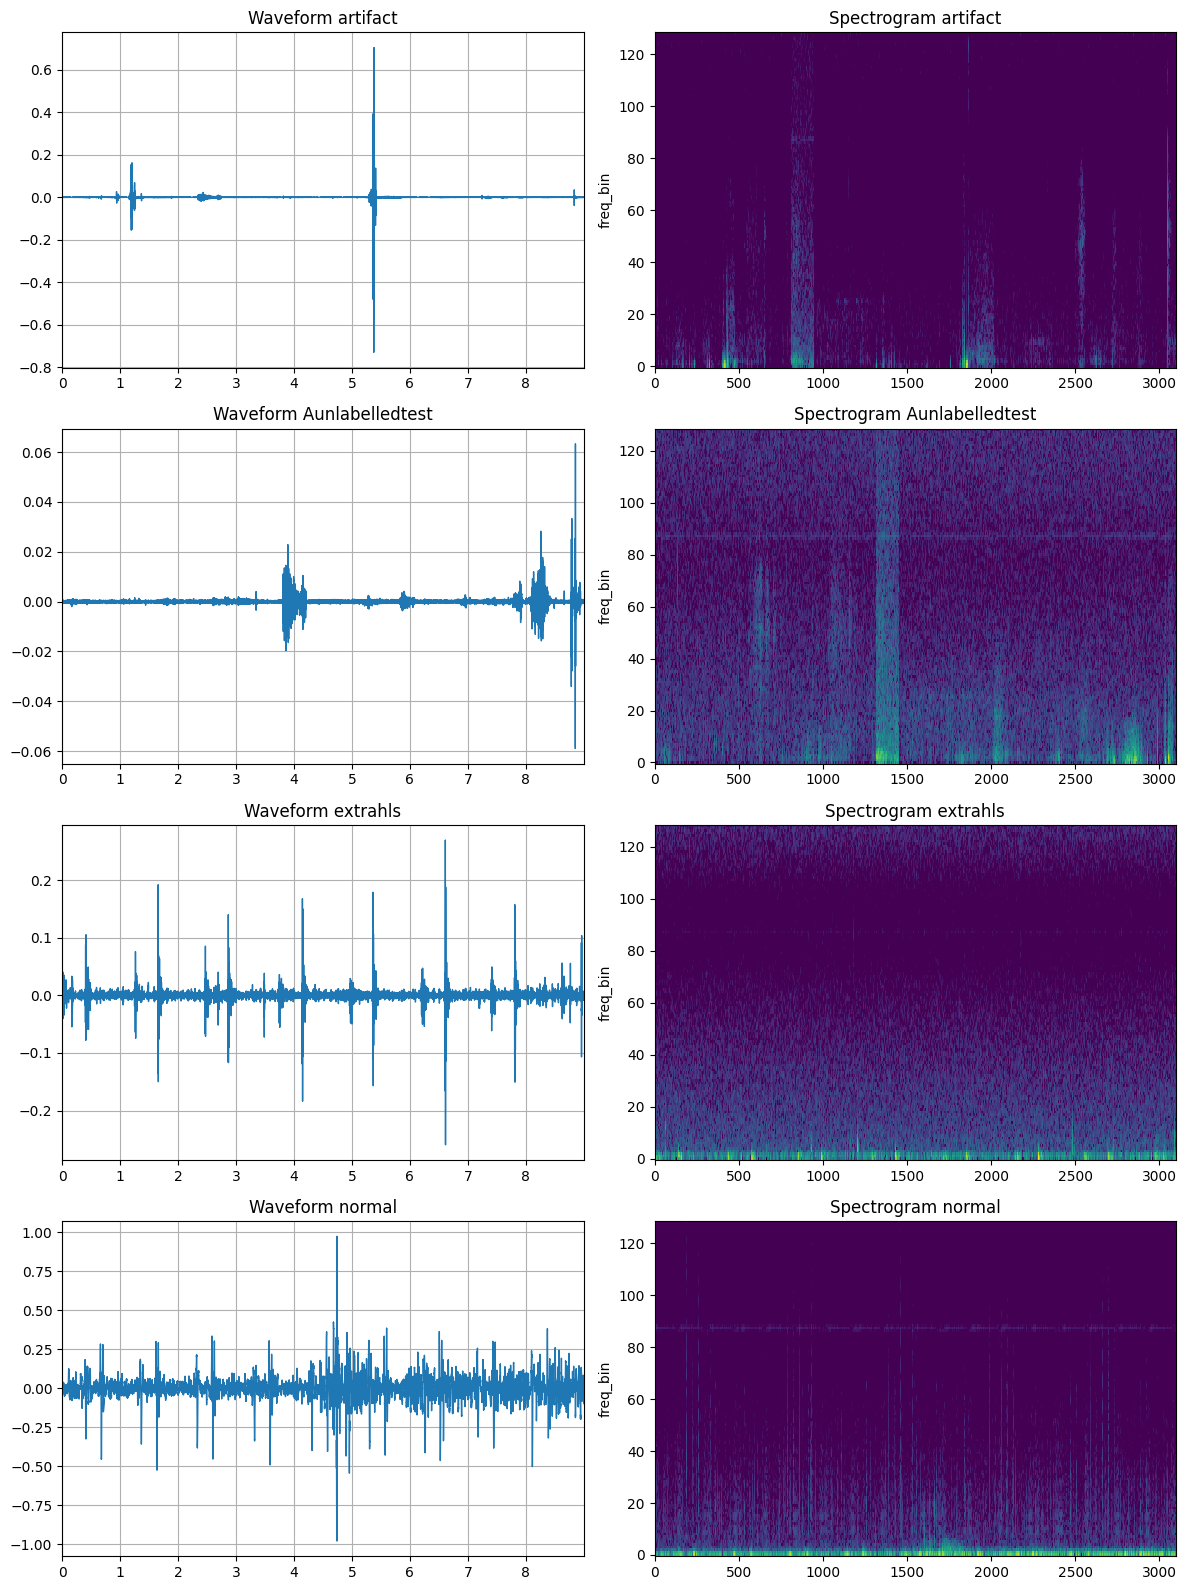

In [7]:
plot_files = ['artifact__201012172012.wav',
              'Aunlabelledtest__201012172010.wav',
              'extrahls__201101091153.wav',
              'normal__201101151127.wav']

plot_wav_n_spec(plot_files)

### Checking one type ... looking for similarities

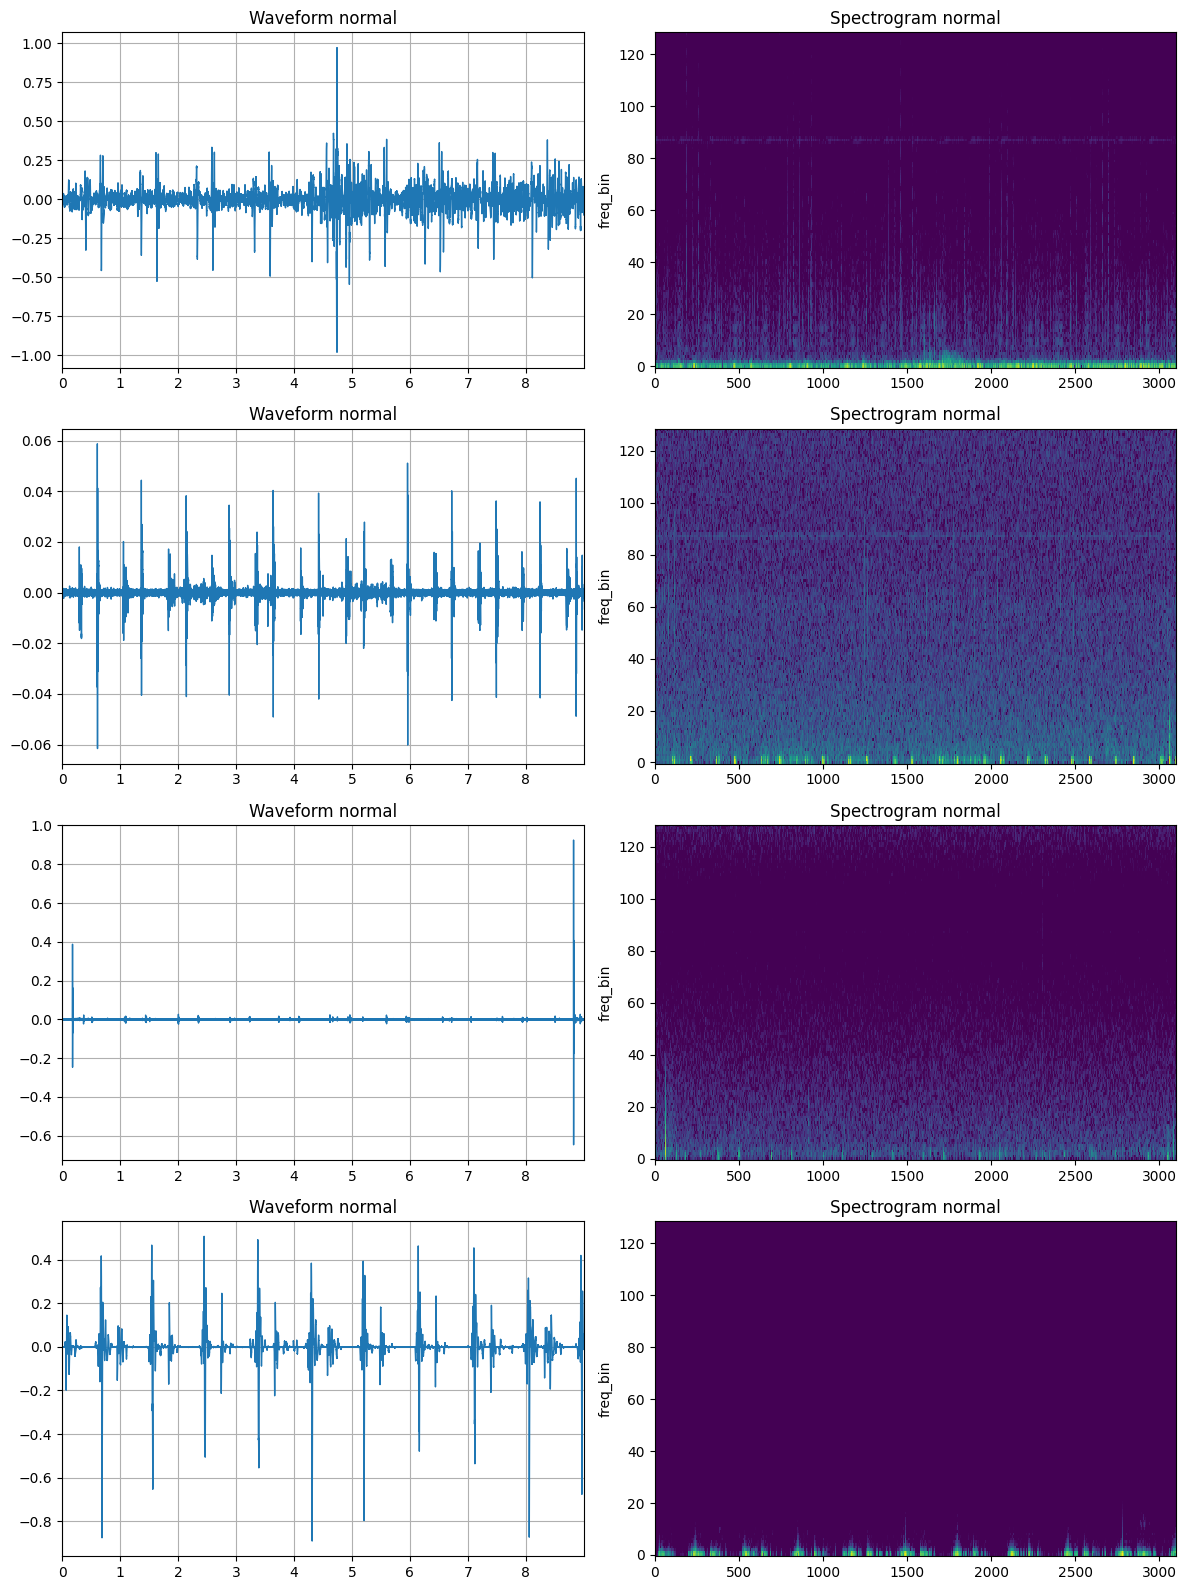

In [8]:
plot_files = ['normal__201101151127.wav',
              'normal__201102201230.wav',
              'normal__201102270940.wav',
              'normal__201103101140.wav']

plot_wav_n_spec(plot_files)

## Data preparation

In [9]:
training_data_path = data_path / 'training_data'
training_data_path.mkdir(exist_ok=True)
train_data_path = training_data_path / 'train'
train_data_path.mkdir(exist_ok=True)
test_data_path = training_data_path / 'test'
test_data_path.mkdir(exist_ok=True)

In [10]:
def spectrogram_to_image(waveform, file_path):
    transform = torchaudio.transforms.Spectrogram(n_fft=256)
    spectrogram = transform(waveform)
    spectrogram = spectrogram.squeeze().numpy()
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
    spectrogram = (spectrogram * 255).astype(np.uint8)
    img = Image.fromarray(spectrogram)
    img.save(file_path)

In [11]:
files = wave_source_path.glob('*')
test_perc = 0.2

create_training_data = False

if create_training_data:
    for file in files:
        if file.is_file():
            waveform, sample_rate = torchaudio.load(file)
            
            leafe_name = file.as_posix().split('/')[-1]
            category, num_suff = leafe_name.split('__')
            if category == 'Aunlabelledtest':
                continue
            rand = random.random()
            if rand < test_perc:
                category_data_path = test_data_path / category
                category_data_path.mkdir(exist_ok=True)
                storage_path = category_data_path / f"{num_suff.split('.')[0]}.png"
                spectrogram_to_image(waveform, storage_path)
            else:
                category_data_path = train_data_path / category
                category_data_path.mkdir(exist_ok=True)
                storage_path = category_data_path / f"{num_suff.split('.')[0]}.png"
                spectrogram_to_image(waveform, storage_path)
        

In [12]:
BATCH_SIZE = 4

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_set = torchvision.datasets.ImageFolder(train_data_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_data_path, transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

In [13]:
class SoundSpectrumCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),  #(8,128,128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                            #(8,64,64)
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1), #(16,64,64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 #(16,32,32)
        )

        self.dense_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*32*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )

    def forward(self, x):
        return self.dense_stack(self.conv_stack(x))
        

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
model = SoundSpectrumCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device: cpu


In [15]:
EPOCHS = 100

train_accs = []
train_losses = []
test_accs = []
test_losses = []

for epoch in range(EPOCHS):

    train_acc = 0
    train_loss = 0

    model.train()
    for batch_num, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        y_pred = model(X)
        #print(f'X: {X}')
        #print(f'y_pred: {y_pred}')
        #print(f'y: {y}')
        loss_result = loss_fn(y_pred, y)
        loss_result.backward()
        optimizer.step()

        y_pred_class = y_pred.argmax(dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

        train_loss += loss_result.item()

    train_acc = train_acc / len(train_loader)
    train_accs.append(train_acc)
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    test_acc = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
    
            y_pred = model(X)
            loss_result = loss_fn(y_pred, y)
    
            y_pred_class = y_pred.argmax(dim=1)
            test_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
            test_loss += loss_result.item()

    test_acc = test_acc / len(test_loader)
    test_accs.append(test_acc)
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f'Train acc: {train_acc:3f} | Train loss: {train_loss:3f} | Test acc: {test_acc:3f} | Test loss: {test_loss:3f}')

    

Train acc: 0.387097 | Train loss: 1.276659 | Test acc: 0.548387 | Test loss: 1.128030
Train acc: 0.556452 | Train loss: 1.067762 | Test acc: 0.580645 | Test loss: 1.010373
Train acc: 0.572581 | Train loss: 1.000025 | Test acc: 0.556452 | Test loss: 0.978150
Train acc: 0.556452 | Train loss: 0.929417 | Test acc: 0.596774 | Test loss: 0.872276
Train acc: 0.580645 | Train loss: 0.880196 | Test acc: 0.604839 | Test loss: 0.820949
Train acc: 0.596774 | Train loss: 0.809896 | Test acc: 0.677419 | Test loss: 0.750470
Train acc: 0.685484 | Train loss: 0.763752 | Test acc: 0.709677 | Test loss: 0.684360
Train acc: 0.717742 | Train loss: 0.705876 | Test acc: 0.750000 | Test loss: 0.639397
Train acc: 0.717742 | Train loss: 0.674101 | Test acc: 0.717742 | Test loss: 0.631823
Train acc: 0.741935 | Train loss: 0.633237 | Test acc: 0.750000 | Test loss: 0.620648
Train acc: 0.741935 | Train loss: 0.599455 | Test acc: 0.766129 | Test loss: 0.614018
Train acc: 0.645161 | Train loss: 0.796400 | Test acc:

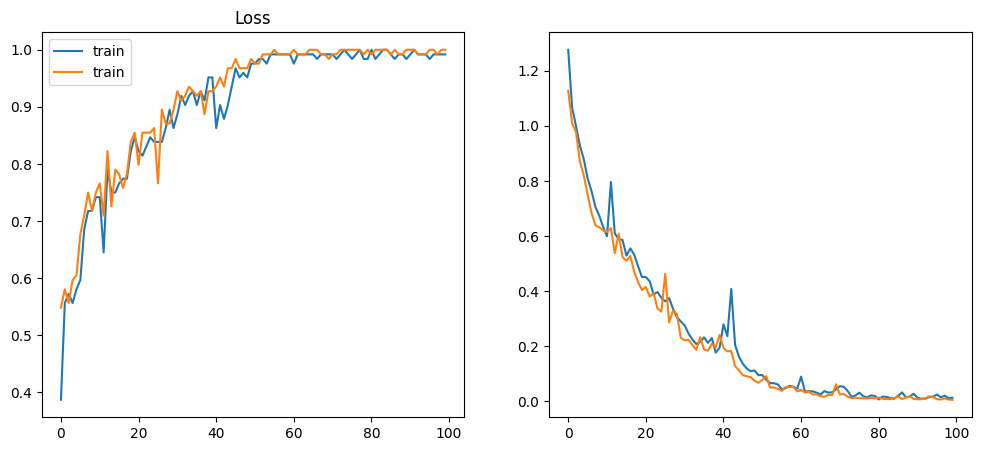

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_accs, label='train')
ax1.plot(test_accs, label='test')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(train_losses, label='train')
ax2.plot(test_losses, label='train')
ax1.set_title('Loss')
plt.show()